In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from tqdm.auto import tqdm, trange
from torch import load
import torch as th
import matplotlib.pyplot as plt


from tools.utils import load_activation_dataset

In [2]:
def compute_dataset_norms(dataset, max_index=None):
    if max_index is None:
        max_index = len(dataset)

    norms = []
    for i in trange(max_index):
        norms.append(dataset[i].norm(dim=1)) # Shape: (2,)
    return th.stack(norms)

def verify_data_integrity(norms, tokens, bos_token_id=2):
    # Check if the norms are the same for the same token
    for i in trange(len(norms)):
        base_norm, chat_norm = norms[i]
        
        # Check that norms aren't too large
        if (base_norm > 1000 or chat_norm > 1000) and tokens[i] != bos_token_id:
            raise ValueError(f"Found norm > 1000 at index {i}: base={base_norm:.1f}, chat={chat_norm:.1f}")
            
        # Check that base and chat norms don't differ too much
        norm_ratio = max(base_norm/chat_norm, chat_norm/base_norm)
        if norm_ratio > 5: # 400% difference threshold
            raise ValueError(f"Base and chat norms differ by >{norm_ratio:.1%} at index {i}: base={base_norm:.1f}, chat={chat_norm:.1f}")

def save_norms(activations_dir, split, dataset_name, layer, norms, base_model="gemma-2-2b", chat_model="gemma-2-2b-it"):
    norms_dir_base = activations_dir / base_model / dataset_name / split / f"layer_{layer}_out"
    norms_dir_chat = activations_dir / chat_model / dataset_name / split / f"layer_{layer}_out"
    assert norms_dir_base.exists(), f"Norms directory {norms_dir_base} does not exist"
    assert norms_dir_chat.exists(), f"Norms directory {norms_dir_chat} does not exist"
    th.save(norms[:, 0], norms_dir_base / "norms.pt")
    th.save(norms[:, 1], norms_dir_chat / "norms.pt")


def plot_norms(norms, tokens= None, filter_bos=False, bos_token_id=2):
    if filter_bos:
        assert tokens is not None, "Tokens must be provided if filtering BOS tokens"
        norms = norms[tokens[:len(norms)] != bos_token_id]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(norms)), norms[:, 0], alpha=0.5, label='Base Model', s=1)
    plt.scatter(range(len(norms)), norms[:, 1], alpha=0.5, label='Chat Model', s=1)
    plt.xlabel('Activation Index')
    plt.ylabel('Activation Norm')
    plt.legend()
    title = f"Activation Norms Comparison"
    if filter_bos:
        title += f" (filtered BOS tokens)"
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


# Train

In [3]:
activations_dir = Path("/workspace/data/activations/")

fineweb_activations, lmsys_activations = load_activation_dataset(
    activation_store_dir=activations_dir,
    base_model="gemma-2-2b",
    instruct_model="gemma-2-2b-it",
    layer=13,
    split="train",
)
len(fineweb_activations), len(lmsys_activations)

Loading fineweb cache from /workspace/data/activations/gemma-2-2b/fineweb-1m-sample/train/layer_13_out and /workspace/data/activations/gemma-2-2b-it/fineweb-1m-sample/train/layer_13_out
Loading lmsys cache from /workspace/data/activations/gemma-2-2b/lmsys-chat-1m-gemma-formatted/train/layer_13_out and /workspace/data/activations/gemma-2-2b-it/lmsys-chat-1m-gemma-formatted/train/layer_13_out


(25834293, 25640426)

In [ ]:
fineweb_norms = compute_dataset_norms(fineweb_activations)
save_norms(activations_dir, "train", "fineweb-1m-sample", 13, fineweb_norms)

In [46]:
verify_data_integrity(fineweb_norms, fineweb_activations.tokens[0])

  0%|          | 0/25834293 [00:00<?, ?it/s]

In [ ]:
plot_norms(fineweb_norms[:1_000_000], tokens=fineweb_activations.tokens[0].cpu(), filter_bos=True)

In [4]:
lmsys_norms = compute_dataset_norms(lmsys_activations)
save_norms(activations_dir, "train", "lmsys-chat-1m-gemma-formatted", 13, lmsys_norms)

  0%|          | 0/25640426 [00:00<?, ?it/s]

In [6]:
verify_data_integrity(lmsys_norms, lmsys_activations.tokens[0])

  0%|          | 0/25640426 [00:00<?, ?it/s]

# Validation

In [9]:
fineweb_activations, lmsys_activations = load_activation_dataset(
    activation_store_dir=activations_dir,
    base_model="gemma-2-2b",
    instruct_model="gemma-2-2b-it",
    layer=13,
    split="validation",
)
len(fineweb_activations), len(lmsys_activations)

Loading fineweb cache from /workspace/data/activations/gemma-2-2b/fineweb-1m-sample/validation/layer_13_out and /workspace/data/activations/gemma-2-2b-it/fineweb-1m-sample/validation/layer_13_out
Loading lmsys cache from /workspace/data/activations/gemma-2-2b/lmsys-chat-1m-gemma-formatted/validation/layer_13_out and /workspace/data/activations/gemma-2-2b-it/lmsys-chat-1m-gemma-formatted/validation/layer_13_out


(5204776, 5104976)

  0%|          | 0/5204776 [00:00<?, ?it/s]

  0%|          | 0/5204776 [00:00<?, ?it/s]

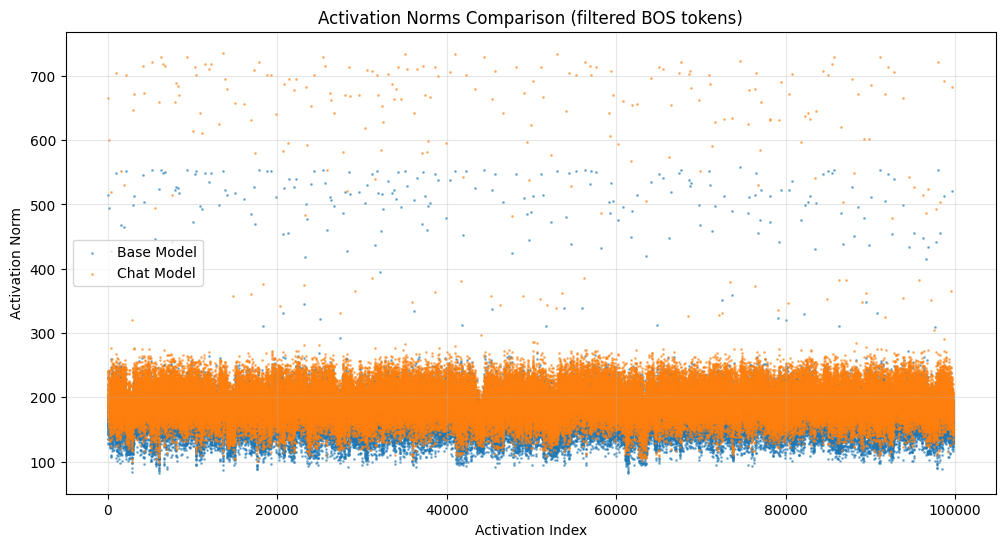

In [10]:
fineweb_norms = compute_dataset_norms(fineweb_activations)
save_norms(activations_dir, "validation", "fineweb-1m-sample", 13, fineweb_norms)
verify_data_integrity(fineweb_norms, fineweb_activations.tokens[0])
plot_norms(fineweb_norms[:100_000], tokens=fineweb_activations.tokens[0].cpu(), filter_bos=True)

  0%|          | 0/5104976 [00:00<?, ?it/s]

  0%|          | 0/5104976 [00:00<?, ?it/s]

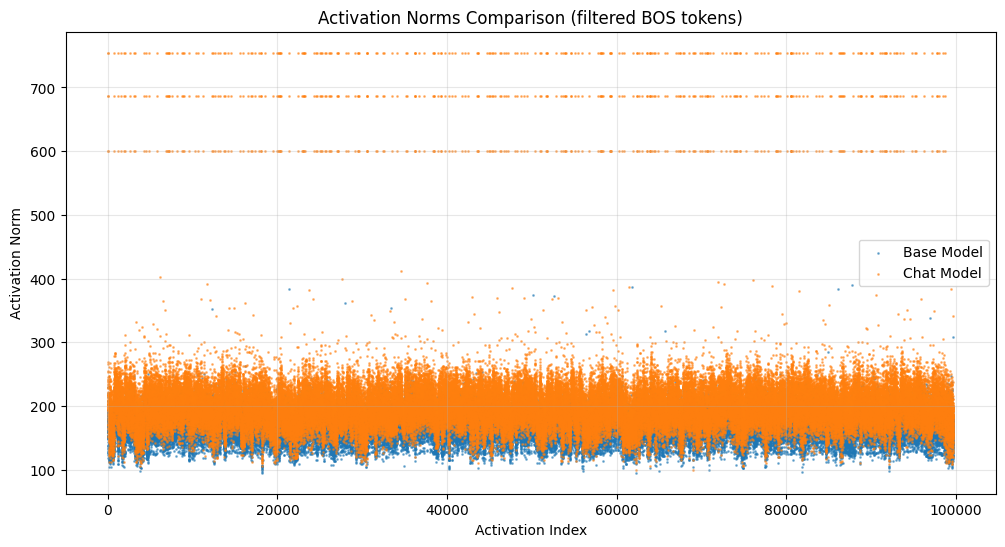

In [11]:
lmsys_norms = compute_dataset_norms(lmsys_activations)
save_norms(activations_dir, "validation", "lmsys-chat-1m-gemma-formatted", 13, lmsys_norms)
verify_data_integrity(lmsys_norms, lmsys_activations.tokens[0])
plot_norms(lmsys_norms[:100_000], tokens=lmsys_activations.tokens[0].cpu(), filter_bos=True)

In [16]:
max_nonbos_norm = lmsys_norms[lmsys_activations.tokens[0].cpu() != 2].max()
max_nonbos_norm_idx = lmsys_norms[lmsys_activations.tokens[0].cpu() != 2].argmax()
max_nonbos_norm, max_nonbos_norm_idx


(tensor(754.5128), tensor(610273))